In [8]:
import pandas as pd
import os
from loguru import logger
import pandas_gbq
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import numpy as np
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

# Set up logging
log_dir = os.path.join(os.getcwd(), "logs")
os.makedirs(log_dir, exist_ok=True)
logger.add(os.path.join(log_dir, "feature_engineering.log"))


2

### Initial analysis

In [12]:
# Load data
df = pd.read_csv('raw-data.csv')
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
df.head()

Dataset Shape: (67279, 13)
Memory Usage: 22.27 MB


,customer_id,merchant_id,loan_type,first_funded_date,tbl_loan_id,transaction_id,face_amount,transaction_date,loan_total_due,loan_repaid_amounts,loan_repayment_rate,loan_repay_days,loan_shortfall
0,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554782,8580,2024-05-27,8786.0,8785.0,100.0,-5,1.0
1,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554812,2956,2024-05-27,8786.0,8785.0,100.0,-5,1.0
2,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554776,8575,2024-05-27,8786.0,8785.0,100.0,-5,1.0
3,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554800,8432,2024-05-27,8786.0,8785.0,100.0,-5,1.0
4,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554805,8224,2024-05-27,8786.0,8785.0,100.0,-5,1.0


In [26]:
# data info and datatypes
print(f"Data contains: {len(df)} transactions with {df['customer_id'].nunique()} customers")
print("\nData Info:\n")
print(df.info())
print("\nData Types:\n", df.dtypes)

Data contains: 67279 transactions with 971 customers

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67279 entries, 0 to 67278
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            67279 non-null  int64         
 1   merchant_id            67279 non-null  object        
 2   loan_type              67279 non-null  object        
 3   first_funded_date      67279 non-null  datetime64[ns]
 4   tbl_loan_id            67279 non-null  int64         
 5   transaction_id         67279 non-null  int64         
 6   face_amount            67279 non-null  int64         
 7   transaction_date       67279 non-null  datetime64[ns]
 8   loan_total_due         67279 non-null  float64       
 9   loan_repaid_amounts    67279 non-null  float64       
 10  loan_repayment_rate    67279 non-null  float64       
 11  loan_repay_days        67279 non-null  int64         

In [ ]:
#check summary for numerical columns
num_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col not in ['customer_id', 'transaction_id', 'tbl_loan_id']
]

df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
face_amount,67279.0,9574.957282,15701.840892,0.0,2756.0,5230.0,10170.0,558590.0
loan_total_due,67279.0,11525.369402,12099.122906,65.0,5097.0,6590.0,13260.0,138123.0
loan_repaid_amounts,67279.0,10828.006912,11627.983692,0.0,4942.0,6179.0,12576.0,103501.0
loan_repayment_rate,67279.0,94.559937,21.637687,0.0,100.0,100.0,100.0,100.0
loan_repay_days,67279.0,15.227010,71.906974,-7.0,-2.0,-1.0,0.0,443.0
loan_shortfall,67279.0,697.362491,4834.687711,0.0,0.0,0.0,0.0,138123.0
days_before_loan,67279.0,45.725694,54.253582,1.0,14.0,23.0,56.0,406.0


Insights: 

- The average loan amount is ~9.6K, but values range widely up to 558K, indicating a highly skewed distribution with some large-value outliers.
- On average, borrowers owe ~11.5K, slightly higher than the face amount due to interest or fees, with a wide range up to 138K.
- The average repaid amount is ~10.8K, showing that most customers repay a significant portion of their dues, although some repay nothing (min = 0).
- While the mean repayment rate is ~94.6%, the median is 100%, indicating that most loans are fully repaid; however, a minority fully default, creating class imbalance.
- Repayment timing varies widely, with a mean delay of 15 days but a median of -1, suggesting most borrowers repay on or before the due date, while a few repay extremely late.
- Although the average shortfall is ~697, 75% of loans have zero shortfall, showing that financial risk is concentrated in a small group of defaulters.
- Borrowers typically have ~46 days of transaction history before receiving a loan

In [50]:
# Convert dates
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['first_funded_date'] = pd.to_datetime(df['first_funded_date'])

#print min transaction date and max transaction date
print(f"Transaction Date Range: {df['transaction_date'].min()} to {df['transaction_date'].max()}")
#print min first funded date and max first funded date
print(f"First Funded Date Range: {df['first_funded_date'].min()} to {df['first_funded_date'].max()}")

Transaction Date Range: 2024-04-29 00:00:00 to 2025-07-08 00:00:00
First Funded Date Range: 2024-05-03 00:00:00 to 2025-07-30 00:00:00


In [37]:
# check missing values

missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("\nMissing Values Summary:\n", missing_summary)

# Percentage of missing values
missing_percentage = (df.isnull().mean() * 100).round(2)
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print("\nMissing Values Percentage:\n", missing_percentage)

    


Missing Values Summary:
 Series([], dtype: int64)

Missing Values Percentage:
 Series([], dtype: float64)


Insight: Means no missing data. However we have  amounts equal to 0!

In [117]:
# Repayment behaviour
print("\nRepayment behaviour distribution:")
df['repayment_performance'] = np.select([
    df['loan_repayment_rate'] >= 100,
    df['loan_repayment_rate'] >= 90,
    df['loan_repayment_rate'] >= 70,
    df['loan_repayment_rate'] < 70
], ['Excellent', 'Good', 'Fair', 'Poor'], default='Unknown')

repayment_analysis = df.groupby('repayment_performance').agg({
    'customer_id': 'count',
    'loan_repayment_rate': ['mean', 'std'],
    'loan_repay_days': ['mean', 'std'],
    'loan_shortfall': ['mean', 'sum']
}).round(2)

print("Repayment Performance Distribution:")
print(repayment_analysis)

#visualize
fig = px.histogram(df, x='loan_repayment_rate', nbins=50, title='Loan Repayment Rate Distribution')
fig.show()  
# fig = px.histogram(df, x='loan_repay_days', nbins=50, title='Loan Repay Days Distribution')
# fig.show()


Repayment behaviour distribution:
Repayment Performance Distribution:
                      customer_id loan_repayment_rate        loan_repay_days  \
                            count                mean    std            mean   
repayment_performance                                                          
Excellent                   63036              100.00   0.00            0.57   
Fair                          128               72.36   0.68           59.96   
Good                           34               95.50   0.51           -0.50   
Poor                         4081               11.22  17.33          240.42   

                              loan_shortfall              
                          std           mean         sum  
repayment_performance                                     
Excellent               18.43           0.02      1244.0  
Fair                   114.01        1747.52    223682.0  
Good                     1.52        1199.00     40766.0  
Poor          

Insight: Close to 94% are excellent customers, poor accounts are 4%. Could lead to potential class imbalance

In [ ]:
# days taken to repay loan
df['loan_repay_days_ceil'] = np.ceil(df['loan_repay_days']).astype(int)

# plot
repay_days19 = df[df['loan_repay_days_ceil'] <= 19]['loan_repay_days_ceil']

fig = px.histogram(
    repay_days19, 
    nbins=19, 
    title='Distribution of Repayment Days (<=19 days)',
    labels={'value':'Days to Repay', 'count':'Number of Loans'}
)
fig.show()


Insight:

Most custormer take not more than 7 days.

In [118]:
# days to repay cumulative distribution
repay_days = df['loan_repay_days'].dropna()
sorted_days = np.sort(repay_days)
cumulative_percent = np.arange(1, len(sorted_days)+1) / len(sorted_days) * 100

# Put in a DataFrame
cum_df = pd.DataFrame({
    'days_to_repay': sorted_days,
    'cumulative_percent': cumulative_percent
})

thresholds = [1,3, 5, 7, 10, 14, 30]

for t in thresholds:
    pct = cum_df[cum_df['days_to_repay'] <= t]['cumulative_percent'].max()
    print(f"Threshold: {t} days → {pct:.1f}% of customers repaid by this day")



# visualize

fig = px.line(cum_df, x='days_to_repay', y='cumulative_percent',
              title='Cumulative Distribution of Repayment Days',
              labels={'days_to_repay':'Days to Repay', 'cumulative_percent':'Cumulative Percentage of Customers'})
fig.show()





Threshold: 1 days → 86.0% of customers repaid by this day
Threshold: 3 days → 89.7% of customers repaid by this day
Threshold: 5 days → 90.9% of customers repaid by this day
Threshold: 7 days → 91.9% of customers repaid by this day
Threshold: 10 days → 92.6% of customers repaid by this day
Threshold: 14 days → 92.9% of customers repaid by this day
Threshold: 30 days → 94.4% of customers repaid by this day


In [114]:
# Transaction Patterns
# Calculate days between transaction and loan funding
df['days_before_loan'] = (df['first_funded_date'] - df['transaction_date']).dt.days

transaction_analysis = df.groupby('customer_id').agg({
    'transaction_id': 'count',
    'face_amount': ['sum', 'mean', 'std', 'min', 'max'],
    'days_before_loan': ['min', 'max', 'mean'],
    'loan_repayment_rate': 'mean',
    'tbl_loan_id': 'nunique'
}).round(2)

transaction_analysis.columns = ['_'.join(col).strip() for col in transaction_analysis.columns.values]
transaction_analysis = transaction_analysis.rename(columns={
    'transaction_id_count': 'total_transactions',
    'face_amount_sum': 'total_transaction_amount',
    'face_amount_mean': 'avg_transaction_amount',
    'face_amount_std': 'std_transaction_amount',
    'face_amount_min': 'min_transaction_amount',
    'face_amount_max': 'max_transaction_amount',
    'days_before_loan_min': 'days_since_last_txn',
    'days_before_loan_max': 'days_since_first_txn',
    'days_before_loan_mean': 'avg_days_before_loan',
    'loan_repayment_rate_mean': 'avg_repayment_rate',
    'tbl_loan_id_nunique': 'total_loans'
})

print("Customer-Level Transaction Patterns:")
print(transaction_analysis.describe())


Customer-Level Transaction Patterns:
       total_transactions  total_transaction_amount  avg_transaction_amount  \
count          971.000000              9.710000e+02              971.000000   
mean            69.288363              6.634331e+05            11122.713399   
std             60.732515              1.179311e+06            18045.029285   
min              1.000000              3.000000e+00                1.500000   
25%             23.000000              1.245090e+05             3611.790000   
50%             52.000000              3.039190e+05             5875.610000   
75%             97.000000              7.057910e+05            10717.440000   
max            487.000000              1.545762e+07           298331.360000   

       std_transaction_amount  min_transaction_amount  max_transaction_amount  \
count              964.000000              971.000000              971.000000   
mean              7303.077500             2144.828012            34928.806385   
std     

Insight: Some customers make very high-value transactions (max = 298K). Transactions includes both low- and high-income individuals.

In [ ]:
# Loan-level analysis
loan_analysis = df.groupby('tbl_loan_id').first().reset_index()

loan_summary = loan_analysis.agg({
    'face_amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'loan_total_due': ['mean', 'std'],
    'loan_repayment_rate': ['mean', 'std'],
    'loan_repay_days': ['mean', 'std'],
    'loan_shortfall': ['sum', 'mean']
}).round(2)

print("Loan Portfolio Summary:")
print(loan_summary)


Loan Portfolio Summary:
       face_amount  loan_total_due  loan_repayment_rate  loan_repay_days  \
count       974.00             NaN                  NaN              NaN   
sum    10693276.00             NaN                  NaN              NaN   
mean      10978.72        11723.32                92.55            22.81   
std       21633.70        15854.14                25.15            86.04   
min           0.00             NaN                  NaN              NaN   
max      311900.00             NaN                  NaN              NaN   

       loan_shortfall  
count             NaN  
sum        1207400.00  
mean          1239.63  
std               NaN  
min               NaN  
max               NaN  


Insight: Overall repayment performance for most loans with a mean of 92%. Standard deviation of 25% shows moderate variability. Around 11% of total face amount (1.2M out of 10.7M) — a non-trivial default risk exposure.

Monthly Transaction Amounts by Year:
transaction_year              2024        2025
transaction_month_num                         
1                              0.0  17067196.0
2                              0.0   2561601.0
3                              0.0   3230891.0
4                         278000.0    663620.0
5                      143069192.0   1027660.0
6                       33698974.0   1252296.0
7                      278176479.0    132136.0
8                       49687480.0         0.0
9                       46949499.0         0.0
10                      47586399.0         0.0
11                      15027006.0         0.0
12                       3785122.0         0.0
Monthly Transaction Trends:
                   transaction_id  face_amount  customer_id  \
transaction_month                                             
2025-02                       206      2561601           20   
2025-03                       215      3230891           13   
2025-04                  

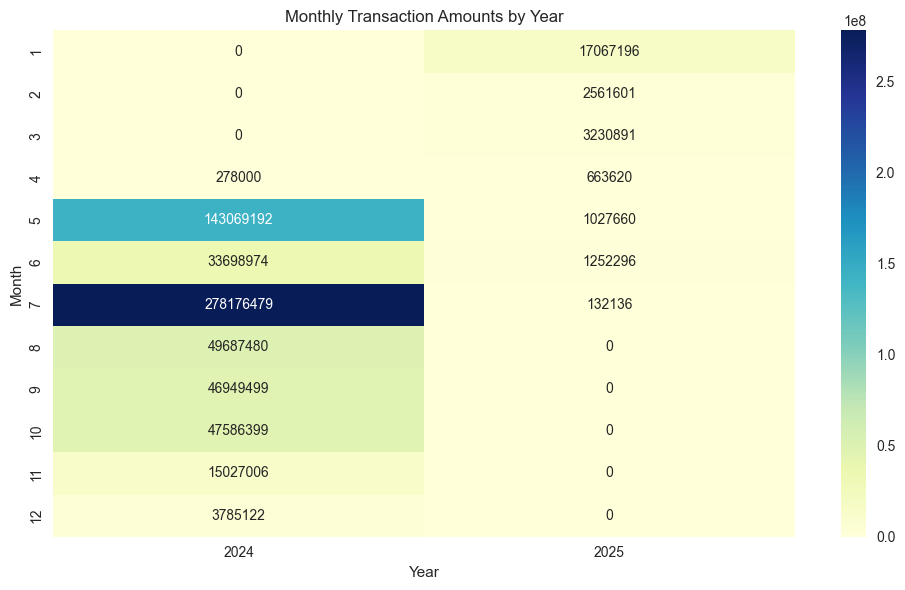

In [ ]:
# temporal trends  
df['transaction_month'] = df['transaction_date'].dt.to_period('M')
df['transaction_year'] = df['transaction_date'].dt.year
df['transaction_month_num'] = df['transaction_date'].dt.month
df['transaction_day_of_week'] = df['transaction_date'].dt.day_name()

# yearly trends
monthly_yearly_trends = df.pivot_table(
    index='transaction_month_num',
    columns='transaction_year',
    values='face_amount',
    aggfunc='sum'
).fillna(0)

print("Monthly Transaction Amounts by Year:")
print(monthly_yearly_trends)

# Monthly trends

monthly_trends = df.groupby('transaction_month').agg({
    'transaction_id': 'count',
    'face_amount': 'sum',
    'customer_id': 'nunique',
    'loan_repayment_rate': 'mean'
}).round(2)

print("Monthly Transaction Trends:")
print(monthly_trends.tail(6))  # Last 6 months

# Weekly trends
weekly_trends = df.groupby('transaction_day_of_week').agg({
    'transaction_id': 'count',  
    'face_amount': 'sum',
    'customer_id': 'nunique',
    'loan_repayment_rate': 'mean'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).round(2)
print("Weekly Transaction Trends:")
print(weekly_trends)

# visualize trends
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_yearly_trends, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Monthly Transaction Amounts by Year")
plt.xlabel("Year")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

fig = px.line(monthly_trends, x=monthly_trends.index.astype(str), y='face_amount', title='Monthly Transaction Amount')
fig.show()
fig = px.bar(weekly_trends, x=weekly_trends.index, y='face_amount', title='Weekly Transaction Amount')
fig.show()


Insights:

- No transaction activity in early 2024, peaked mid-year, especially in May (143M) and July (278M) likely due to product launch, promotions, or new onboarding.
- In 2025, transactions are concentrated in the first half of the year, with the highest in January (17M) and non existing transaction activities past july.
- February had the highest transaction volume in 2025, with 20 customers and 206 transactions, but slightly lower repayment rate (92.9%) than later months.
- Most transaction activity occurred midweek, especially on Wednesdays (30K transactions, 303M face amount) and Tuesdays (18.5K, 192M) suggesting peak customer engagement during weekdays.
- Loan repayment performance was best on Tuesdays (96.55%) and Wednesdays (95.31%), and worst on Fridays (84.40%), possibly due to behavioral or operational factors.
- Weekends showed minimal transaction activity and slightly lower repayment performance, highlighting lower engagement and possibly less financial discipline

Customer Risk Distribution:
risk_category
Very Low Risk    887
High Risk         31
Medium Risk        4
Low Risk           1
Name: count, dtype: int64


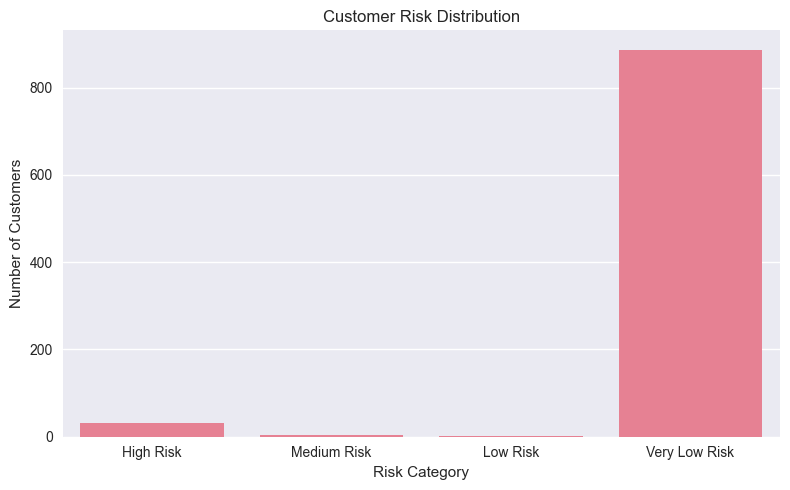

In [ ]:
# Customer risk profiling
risk_indicators = df.groupby('customer_id').agg({
    'loan_shortfall': 'sum',
    'loan_repay_days': 'max',
    'face_amount': 'std',
    'transaction_id': 'count',
    'loan_repayment_rate': 'min'
}).round(2)

risk_indicators.columns = ['total_shortfall', 'max_repay_days', 'txn_amount_volatility', 
                            'transaction_frequency', 'worst_repayment_rate']

# Categorize risk levels
risk_indicators['risk_category'] = pd.cut(
    risk_indicators['worst_repayment_rate'],
    bins=[0, 70, 85, 95, 101],
    labels=['High Risk', 'Medium Risk', 'Low Risk', 'Very Low Risk']
)

risk_distribution = risk_indicators['risk_category'].value_counts()
print("Customer Risk Distribution:")
print(risk_distribution)

# Visualize risk distribution
risk_counts = risk_indicators['risk_category'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=risk_counts.index, y=risk_counts.values)
plt.title('Customer Risk Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Risk Category')
plt.tight_layout()
plt.show()

Insight:

- Majority of customers (~96.4%) fall under the Very Low Risk category (887 out of 923), indicating a highly conservative or well-performing portfolio.
- High Risk customers account for only 3.4% (31 customers), while Medium and Low Risk categories are nearly negligible.
- The distribution is highly imbalanced, which may lead to challenges in training a risk classification model and would require techniques such as resampling or class weighting to address.

In [ ]:

# fig = px.box(df, y='loan_repayment_rate', title='Loan Repayment Rate Box Plot')
# fig.show()
# fig = px.histogram(df, x='loan_repay_days', nbins=50, title='Loan Repay Days Distribution')
# fig.show()
# fig = px.box(df, y='loan_repay_days', title='Loan Repay Days Box Plot')
# fig.show()
# fig = px.histogram(df, x='loan_shortfall', nbins=50, title='Loan Shortfall Distribution')
# fig.show()
# fig = px.box(df, y='loan_shortfall', title='Loan Shortfall Box Plot')
# fig.show()


In [69]:
# def create_directory_if_not_exists(directory_path):
#     os.makedirs(directory_path, exist_ok=True)

# def save_data_for_preprocessing(df):
#     """
#     Save the data to a CSV file for preprocessing in the same directory as the raw data.
#     """
#     try:
#         # Define subdirectory relative to the current working directory
#         subdirectory = os.path.join(
#              "outputs"
#         )
#         filename = "data_for_preprocessing.csv"

#         # Ensure the directory exists
#         create_directory_if_not_exists(subdirectory)

#         # Build the full file path
#         file_path = os.path.join(subdirectory, filename)

#         # Save the DataFrame
#         df.to_csv(path_or_buf=file_path, index=False)
#         print(f"Data successfully saved for preprocessing: {file_path}")

#     except Exception as e:
#         print(f"Error writing model data for preprocessing: {e}")


In [70]:
# Convert transaction_time to naive
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# first_funded_date is already naive, just ensure correct dtype
df['first_funded_date'] = pd.to_datetime(df['first_funded_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67279 entries, 0 to 67278
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              67279 non-null  int64         
 1   merchant_id              67279 non-null  object        
 2   loan_type                67279 non-null  object        
 3   first_funded_date        67279 non-null  datetime64[ns]
 4   tbl_loan_id              67279 non-null  int64         
 5   transaction_id           67279 non-null  int64         
 6   face_amount              67279 non-null  int64         
 7   transaction_date         67279 non-null  datetime64[ns]
 8   loan_total_due           67279 non-null  float64       
 9   loan_repaid_amounts      67279 non-null  float64       
 10  loan_repayment_rate      67279 non-null  float64       
 11  loan_repay_days          67279 non-null  int64         
 12  loan_shortfall           67279 n

In [67]:

df['days_before_loan'] = (df['first_funded_date'] - df['transaction_date']).dt.days
df.head()

,customer_id,merchant_id,loan_type,first_funded_date,tbl_loan_id,transaction_id,face_amount,transaction_date,loan_total_due,loan_repaid_amounts,loan_repayment_rate,loan_repay_days,loan_shortfall,repayment_performance,days_before_loan,transaction_month,transaction_day_of_week,transaction_year,transaction_month_num
0,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554782,8580,2024-05-27,8786.0,8785.0,100.0,-5,1.0,Excellent,2,2024-05,Monday,2024,5
1,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554812,2956,2024-05-27,8786.0,8785.0,100.0,-5,1.0,Excellent,2,2024-05,Monday,2024,5
2,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554776,8575,2024-05-27,8786.0,8785.0,100.0,-5,1.0,Excellent,2,2024-05,Monday,2024,5
3,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554800,8432,2024-05-27,8786.0,8785.0,100.0,-5,1.0,Excellent,2,2024-05,Monday,2024,5
4,306558,VF-CUST-2023-12544,VICTORY_FARMS,2024-05-29,366670,67554805,8224,2024-05-27,8786.0,8785.0,100.0,-5,1.0,Excellent,2,2024-05,Monday,2024,5


In [71]:
#create receency, frequency, monetary value (RFM) features for each customer since our data is at transaction level
recency = df.groupby(['customer_id', 'merchant_id']).agg(
    last_txn_days=('days_before_loan', 'min'),   # days since most recent transaction
    first_txn_days=('days_before_loan', 'max'),  # days since oldest transaction
    txn_days_range=('days_before_loan', lambda x: x.max() - x.min())
).reset_index()

recency.head()


,customer_id,merchant_id,last_txn_days,first_txn_days,txn_days_range
0,579,543850,4,6,2
1,870,VF-CUST-2024-00656,18,18,0
2,967,VF-CUST-2023-28119,10,10,0
3,1619,VF-CUST-2023-13656,17,81,64
4,2257,VF-CUST-2023-08596,10,23,13


In [72]:
# Transactions in last 30 days
recent_1m = df[df['days_before_loan'] <= 30]

agg_1m = recent_1m.groupby('customer_id').agg(
    txn_count_1m=('transaction_id','count'),
    sum_amount_1m=('face_amount','sum'),
    avg_amount_1m=('face_amount','mean'),
    max_amount_1m=('face_amount','max'),
    min_amount_1m=('face_amount','min')
).reset_index()

# Transactions in last 90 days
recent_3m = df[df['days_before_loan'] <= 90]

agg_3m = recent_3m.groupby('customer_id').agg(
    txn_count_3m=('transaction_id','count'),
    sum_amount_3m=('face_amount','sum'),
    avg_amount_3m=('face_amount','mean')
).reset_index()

recent_6m = df[df['days_before_loan'] <= 180]

agg_6m = recent_6m.groupby('customer_id').agg(
    txn_count_6m=('transaction_id','count'),    
    sum_amount_6m=('face_amount','sum'),
    avg_amount_6m=('face_amount','mean')
).reset_index()




In [73]:
# Aggregate transactional features per merchant/customer
df_txn_agg = df.groupby('merchant_id').agg(
    total_transactions = ('transaction_id', 'count'),
    total_transaction_amount = ('face_amount', 'sum'),
    avg_transaction_amount = ('face_amount', 'mean'),
    median_transaction_amount = ('face_amount', 'median'),
    max_transaction_amount = ('face_amount', 'max'),
    min_transaction_amount = ('face_amount', 'min'),
    std_transaction_amount = ('face_amount', 'std')
).reset_index()

In [74]:
# merge all features into a single dataframe
df_features = recency.merge(agg_1m, on='customer_id', how='left') \
                     .merge(agg_3m, on='customer_id', how='left') \
                     .merge(agg_6m, on='customer_id', how='left') \
                     .merge(df_txn_agg, on='merchant_id', how='left')

df_features.head()


,customer_id,merchant_id,last_txn_days,first_txn_days,txn_days_range,txn_count_1m,sum_amount_1m,avg_amount_1m,max_amount_1m,min_amount_1m,...,txn_count_6m,sum_amount_6m,avg_amount_6m,total_transactions,total_transaction_amount,avg_transaction_amount,median_transaction_amount,max_transaction_amount,min_transaction_amount,std_transaction_amount
0,579,543850,4,6,2,2.0,3.0,1.500000,2.0,1.0,...,2,3,1.500000,2,3,1.500000,1.5,2,1,0.707107
1,870,VF-CUST-2024-00656,18,18,0,67.0,718131.0,10718.373134,13585.0,742.0,...,67,718131,10718.373134,67,718131,10718.373134,11377.0,13585,742,2165.705713
2,967,VF-CUST-2023-28119,10,10,0,62.0,193663.0,3123.596774,8050.0,352.0,...,62,193663,3123.596774,62,193663,3123.596774,2651.0,8050,352,1557.888824
3,1619,VF-CUST-2023-13656,17,81,64,115.0,2793151.0,24288.269565,44320.0,77.0,...,116,2829139,24389.129310,116,2829139,24389.129310,27020.5,44320,77,10090.424620
4,2257,VF-CUST-2023-08596,10,23,13,167.0,840548.0,5033.221557,20024.0,345.0,...,167,840548,5033.221557,167,840548,5033.221557,4585.0,20024,345,2706.143545


In [75]:
# we notice that for some features there are NaN values. This is because some customers may not have transacted in the last 30, 90 or 180 days. We will fill these NaN values with 0 as it makes sense to assume that if a
df_features.fillna(0, inplace=True)
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                972 non-null    int64  
 1   merchant_id                972 non-null    object 
 2   last_txn_days              972 non-null    int64  
 3   first_txn_days             972 non-null    int64  
 4   txn_days_range             972 non-null    int64  
 5   txn_count_1m               972 non-null    float64
 6   sum_amount_1m              972 non-null    float64
 7   avg_amount_1m              972 non-null    float64
 8   max_amount_1m              972 non-null    float64
 9   min_amount_1m              972 non-null    float64
 10  txn_count_3m               972 non-null    float64
 11  sum_amount_3m              972 non-null    float64
 12  avg_amount_3m              972 non-null    float64
 13  txn_count_6m               972 non-null    int64  

In [76]:
# Select non-aggregated repayment fields
repay_info = df[['merchant_id', 'loan_total_due', 'loan_repaid_amounts', 'loan_repayment_rate', 'loan_repay_days', 'loan_shortfall']].drop_duplicates()

# Merge aggregated transactions with repayment info
df_final = df_features.merge(repay_info, on='merchant_id', how='left')
df_final.head()

,customer_id,merchant_id,last_txn_days,first_txn_days,txn_days_range,txn_count_1m,sum_amount_1m,avg_amount_1m,max_amount_1m,min_amount_1m,...,avg_transaction_amount,median_transaction_amount,max_transaction_amount,min_transaction_amount,std_transaction_amount,loan_total_due,loan_repaid_amounts,loan_repayment_rate,loan_repay_days,loan_shortfall
0,579,543850,4,6,2,2.0,3.0,1.500000,2.0,1.0,...,1.500000,1.5,2,1,0.707107,65.0,0.0,0.0,87,65.0
1,870,VF-CUST-2024-00656,18,18,0,67.0,718131.0,10718.373134,13585.0,742.0,...,10718.373134,11377.0,13585,742,2165.705713,11771.0,11771.0,100.0,-1,0.0
2,967,VF-CUST-2023-28119,10,10,0,62.0,193663.0,3123.596774,8050.0,352.0,...,3123.596774,2651.0,8050,352,1557.888824,3612.0,3612.0,100.0,2,0.0
3,1619,VF-CUST-2023-13656,17,81,64,115.0,2793151.0,24288.269565,44320.0,77.0,...,24389.129310,27020.5,44320,77,10090.424620,35001.0,35001.0,100.0,0,0.0
4,2257,VF-CUST-2023-08596,10,23,13,167.0,840548.0,5033.221557,20024.0,345.0,...,5033.221557,4585.0,20024,345,2706.143545,9219.0,9219.0,100.0,-2,0.0


In [77]:
df_final.shape

(975, 28)

In [79]:
# generate summary statistics
summary_stats = df_final.describe().T
print("Final Feature Set Summary Statistics:")

summary_stats

Final Feature Set Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
customer_id,975.0,305689.607179,4.002846e+04,579.0,308799.500000,310516.000000,311556.000000,3.576700e+05
last_txn_days,975.0,14.582564,1.721095e+01,1.0,4.000000,9.000000,17.000000,1.120000e+02
first_txn_days,975.0,52.190769,5.543624e+01,1.0,14.000000,29.000000,73.500000,4.060000e+02
txn_days_range,975.0,37.608205,5.276154e+01,0.0,0.000000,13.000000,61.500000,3.750000e+02
txn_count_1m,975.0,41.713846,4.767480e+01,0.0,9.000000,23.000000,58.500000,3.100000e+02
sum_amount_1m,975.0,382604.760000,7.814911e+05,0.0,41956.500000,133124.000000,400345.000000,1.011163e+07
avg_amount_1m,975.0,8158.850495,1.251772e+04,0.0,2696.766667,4911.923077,8712.155556,1.504200e+05
max_amount_1m,975.0,23883.974359,3.729297e+04,0.0,5635.000000,11564.000000,25863.000000,4.958060e+05
min_amount_1m,975.0,1655.670769,5.556510e+03,0.0,170.500000,735.000000,1550.000000,1.504200e+05
txn_count_3m,975.0,59.514872,5.098653e+01,0.0,21.000000,46.000000,84.000000,3.100000e+02


average transaction amount is greater than the median >> the data is heavily skewed.

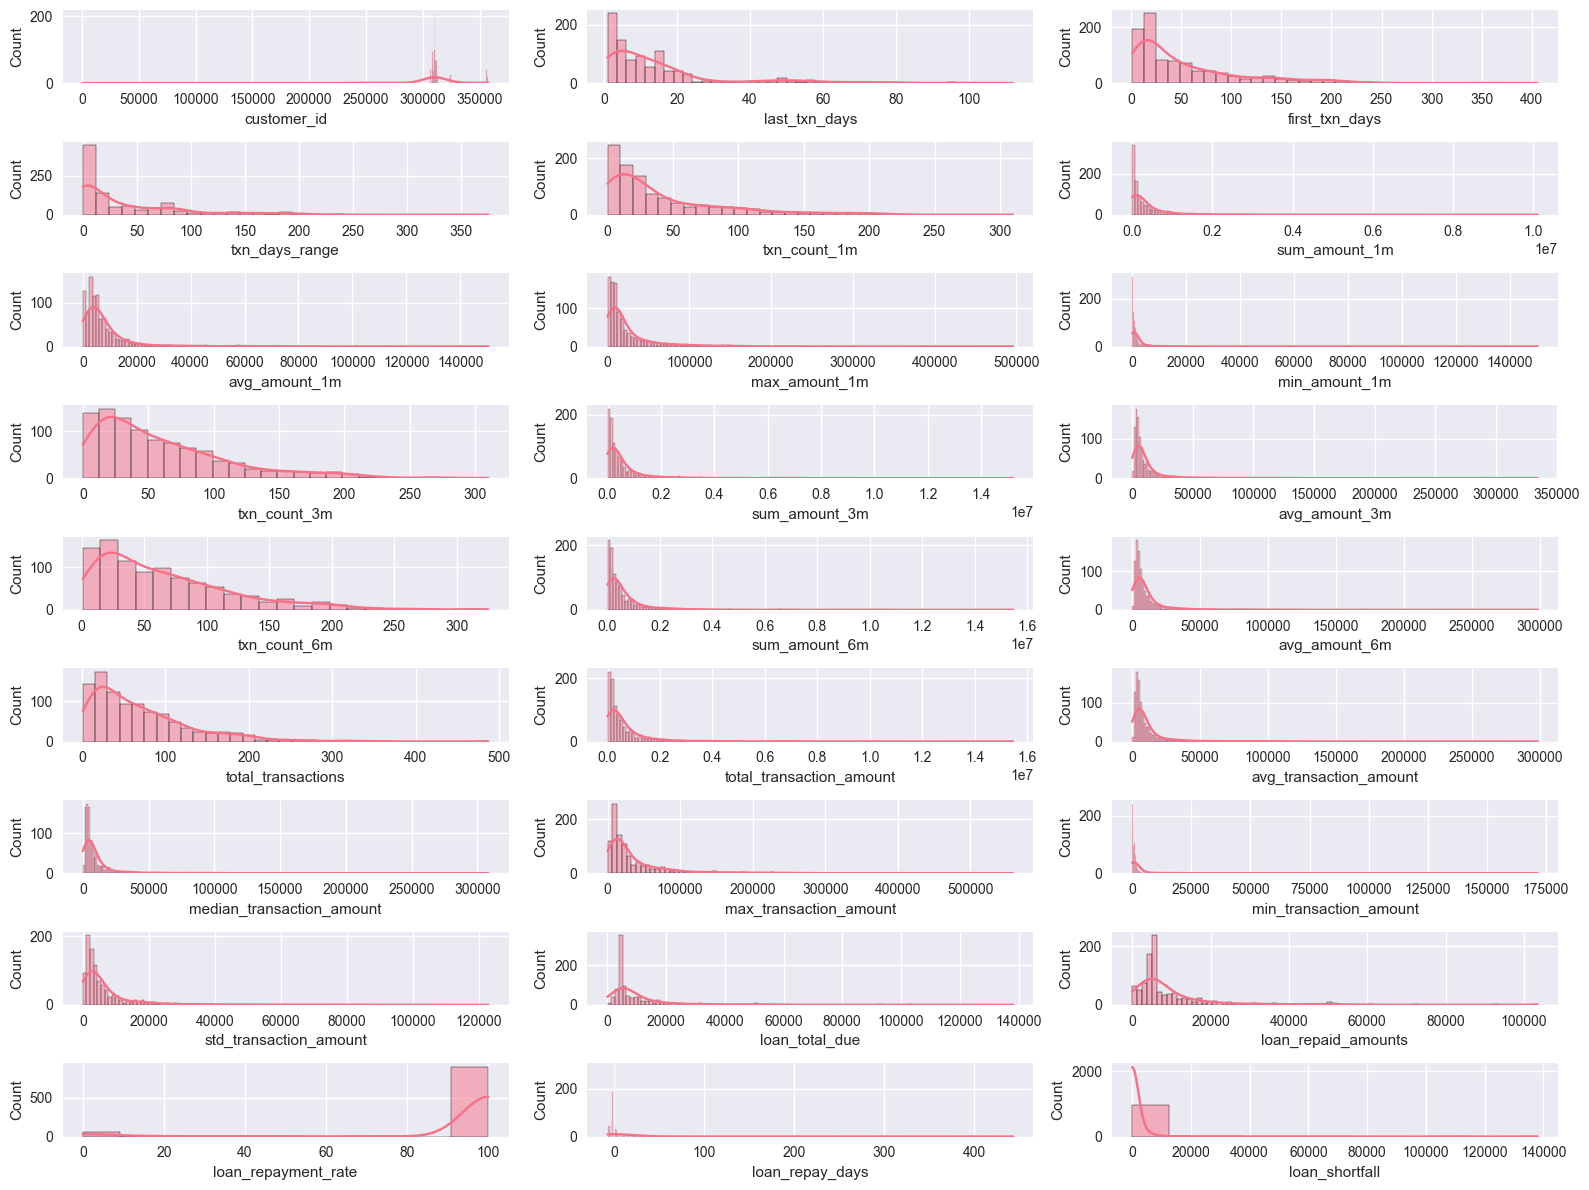

In [ ]:
# plot the distribution of our numerical columns
numerical_cols = df_final.select_dtypes(include=['int64', 'float64']).columns
# Calculate the number of rows and columns for subplots
nrows = (len(numerical_cols) - 1) // 3 + 1
ncols = min(3, len(numerical_cols))

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# Flatten axes if necessary
axes = axes.flatten() if nrows > 1 else [axes]

# Plot numeric features
for i, feature in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(df_final[feature], kde=True, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")

# Remove empty subplots
if len(numerical_cols) < nrows * ncols:
    for i in range(len(numerical_cols), nrows * ncols):
        fig.delaxes(axes[i])

# Adjust subplot spacing
fig.tight_layout()

# Display the plot
plt.show()

The features with amounts in them are all rightly skewed. To avoid bias we will transform them using log transformation



In [107]:
# log transform skewed features
skewed_features = ['total_transaction_amount', 'avg_transaction_amount', 'median_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'std_transaction_amount',
                   'sum_amount_1m', 'avg_amount_1m', 'max_amount_1m', 'min_amount_1m', 
                   'sum_amount_3m', 'avg_amount_3m',        
                     'sum_amount_6m', 'avg_amount_6m', 'txn_count_6m' , 'txn_count_1m' , 'txn_count_3m', 'total_transactions', 'first_txn_days', 'last_txn_days', 'last_txn_days', 'txn_days_range' ]

for feature in skewed_features:
    df_final[feature] = np.where(df_final[feature] > 0, np.log1p(df_final[feature]), 0)


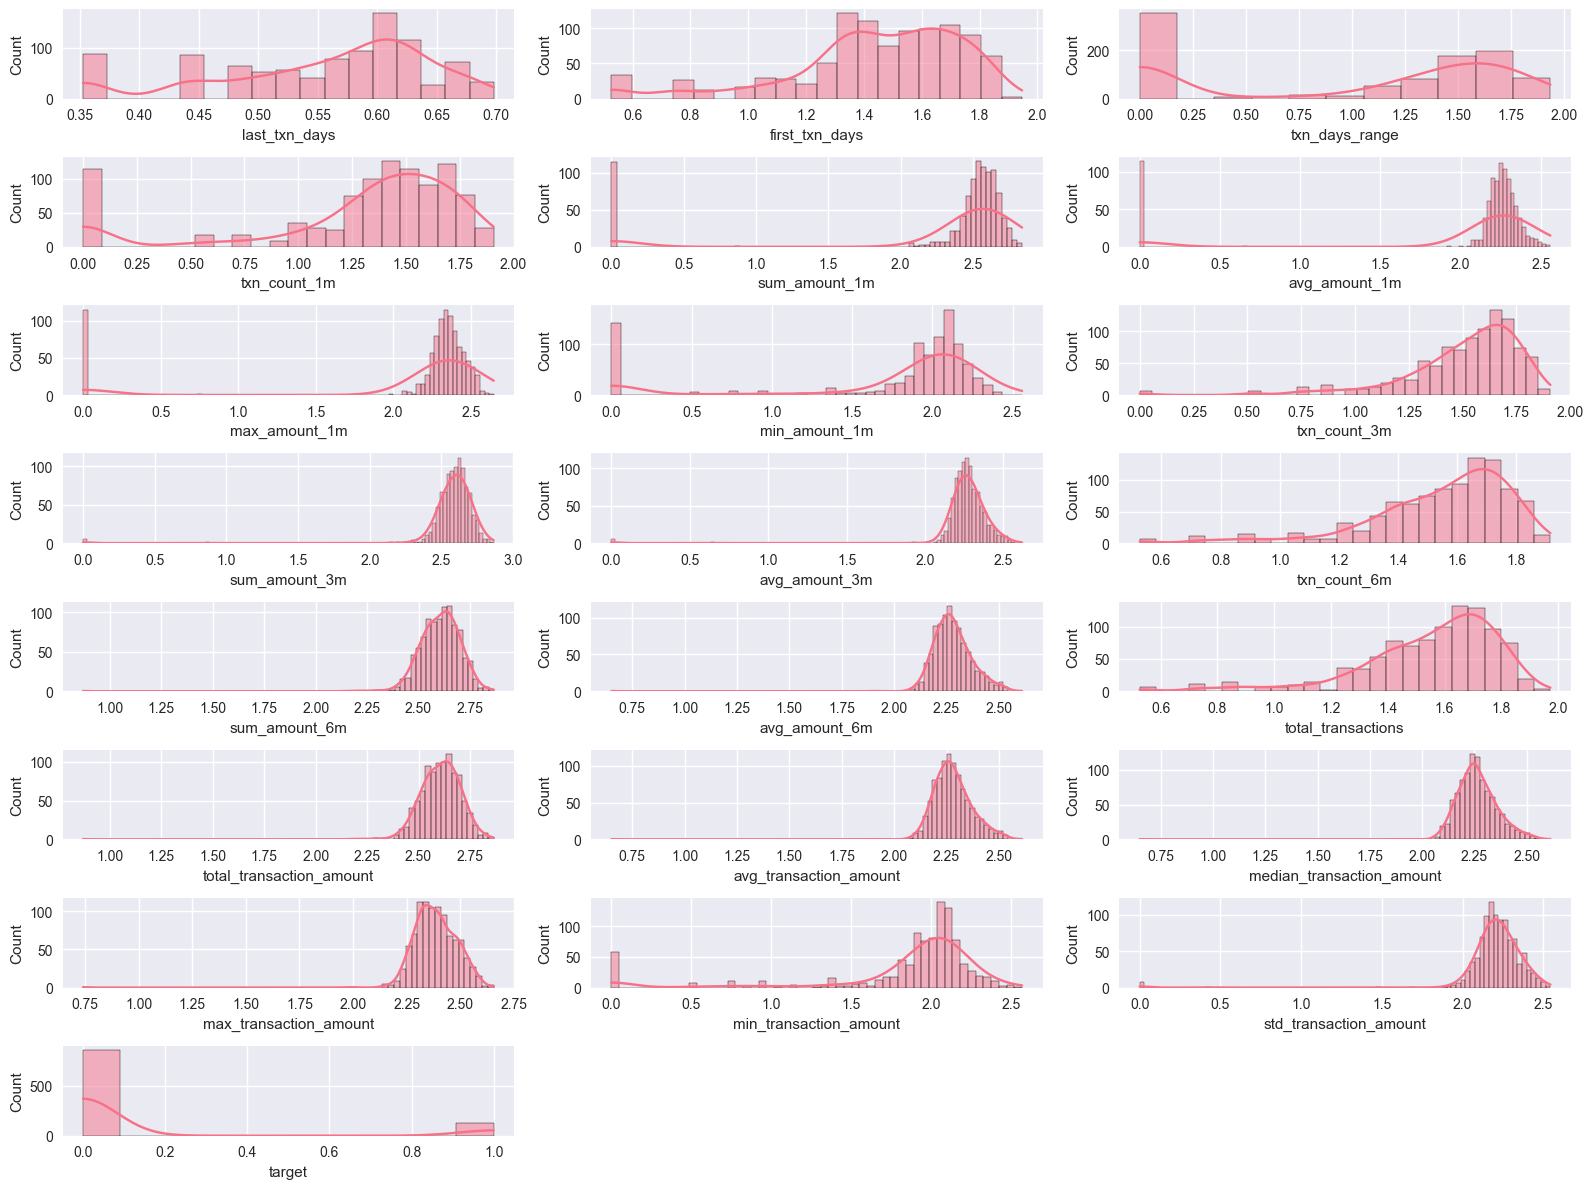

In [108]:
# replotting to identify any changes in distribution

import matplotlib.pyplot as plt
import seaborn as sns
numerical_cols = df_final.select_dtypes(include=['int64', 'float64']).columns
# Calculate the number of rows and columns for subplots
nrows = (len(numerical_cols) - 1) // 3 + 1
ncols = min(3, len(numerical_cols))

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# Flatten axes if necessary
axes = axes.flatten() if nrows > 1 else [axes]

# Plot numeric features
for i, feature in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(df_final[feature], kde=True, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")

# Remove empty subplots
if len(numerical_cols) < nrows * ncols:
    for i in range(len(numerical_cols), nrows * ncols):
        fig.delaxes(axes[i])

# Adjust subplot spacing
fig.tight_layout()

# Display the plot
plt.show()

From the above, there's a class imbalance with the positive class contributing to 11% of the population. To prevent bias, we will need to address this through either Oversampling or another method.


#